[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jmourabarbosa/lowrank_tutorial/blob/main/tutorial1.ipynb)

### uncomment this if running in google colab

In [1]:
# !git clone https://github.com/jmourabarbosa/lowrank_tutorial/
# import sys
# sys.path.append('lowrank_tutorial/')

In [2]:
import numpy as np
import matplotlib.pylab as plt
import lowrank_helpers as lrh
import imp
imp.reload(lrh)

/var/folders/6w/snfd5vc50jb775fq8364m1d80000gn/T/ipykernel_14594/3424911998.py:4: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


<module 'lowrank_helpers' from '/Users/jbarbosa/Dropbox/Neuro/QBio_school/lowrank_tutorial/lowrank_helpers.py'>


# Introduction to (low-rank) recurrent neural networks

### Goals of this tutorial:

* Introduction to recurrent neural networks (RNN)
* basics of low-rank RNN theory (linear)
* basics of low-rank RNN theory (non-linear)

Note: This tutorial is heavily based on the paper and code provided in [(Mastrogiuseppe & Ostojic, 2019)](https://github.com/fmastrogiuseppe/LowRank). For more advance concepts, please refer to that paper.

In a recurrent neural network (RNN), each neuron has a time-dependent membrane voltage $x_i(t)$ and produces a firing rate through the transfer function $\phi(x_i(t))$.

Here, we will use either $\phi(x) = x$ or $\phi = tanh(x)$. To declutter the text, we will drop time and use vector notation.

As the name suggests, neurons in a RNN are recurrently connected so each pair of neurons ${i, j}$ has a synaptic connexion of strength $J_{ij}$.

For the purpose if this tutorial, the recurrent connectivity will be rank 1: $J = \frac{1}{N} mn^T$.

In adition to recurrent inputs, each neuron might be driven by external inputs. For simplicity, we will consider the case of one input $u(t)$ that is fed to each neuron through the weight vector $I$.

Finally, each neuron integrates all its inputs into its voltage via the differential equation:

$$\dot{x} = -x + \frac{1}{N}mn^T\phi(x) + uI$$

Assumming that $m \perp I$, the activity of this network will be confined to a 2D plane defined by $m$ and $I$:

$$x = \kappa m + vI \; \; \; \small (1)$$



# 1. Linear low-rank RNN

***Exercise 1.1.***

An important insight of the low-rank RNN theory is that the alignment between the vectors definning the RNN (in this case $m,n,I$) fully determine the dynamics performed by the network.


<p align="center">
<img src="https://github.com/jmourabarbosa/lowrank_tutorial/blob/main/mastrogiuseppe.png?raw=1" alt="drawing" width="600"/>
</p>



We will gradually develop the intuition (and theory) for why this is the case.

* Which scenario are we for the vectors below m, n, IA?

* How about IB?

In [3]:
m,n,IA,IB = lrh.m, lrh.n, lrh.IA, lrh.IB

N = 1000

lrh.overlaps[0,1] = lrh.overlaps[1,0] = 1.2
lrh.overlaps[1,0] = 1.2

lrh.overlaps[1,2] = lrh.overlaps[2,1] = 1.2

m,n,IA,IB  = np.random.multivariate_normal([0,0,0,0], lrh.overlaps, size=N).T


N=len(m)


In [4]:
def phi(x):
  # toggle between linear and non-linear
  return np.tanh(x)
  return x

***Exercise 1.2***

* Use the following code to run a *linear* rank 1 network with $J = \frac{1}{N}mn^T$ that recieves inputs from IA

* Plot the currents of some neurons.

* Plot the mean activity.

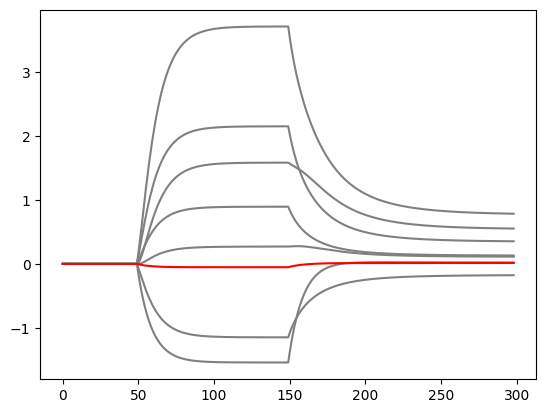

In [5]:


dt = 0.1

time = np.linspace(0,30,int(30//dt))

J = np.outer(m,n) / N
u = np.zeros_like(time)

# inputs are on during this period, off otherwise
u[50:150] = 1

# two trials, one for each input
x = np.zeros([2,N])
X = np.zeros((2,len(time),N))

for ti, _ in enumerate(time):
  x[0] = x[0] + dt*(-x[0] + J @ phi(x[0]) + IA*u[ti])
  x[1] = x[1] + dt*(-x[1] + J @ phi(x[1]) + IB*u[ti])
  X[:,ti,:] = x

plt.plot(X[0,:,:7],"gray")
plt.plot(np.mean(X[1,:],axis=1),"r")

***Exercise 1.3***

Instead of looking at each neuron individually, it is more informative to do dimensionality reduction.

One way of doing this is using PCA. You can try, but given our theory we know that the actvity of x is going to be in m-I plane (equation 1, above).

* Check this fact by projecting the activity on m and I, separatedly, then together.

* Can you guess how many PCs would PCA return?

([], [])

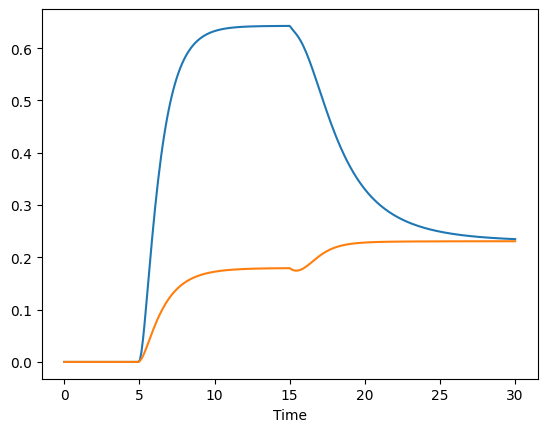

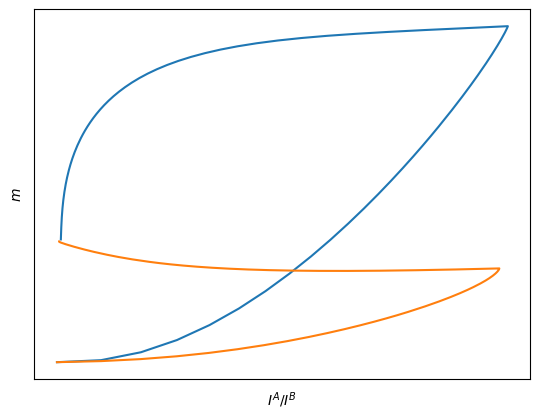

In [6]:
plt.plot(time,X[0] @ m / np.linalg.norm(m)**2)
plt.plot(time,X[1] @ m / np.linalg.norm(m)**2)
plt.xlabel("Time")

plt.figure()
plt.plot(X[0] @ IA / np.linalg.norm(IA)**2,X[0] @ m / np.linalg.norm(m)**2)
plt.plot(X[1] @ IB / np.linalg.norm(IB)**2,X[1] @ m / np.linalg.norm(m)**2)
plt.xlabel('$I^A / I^B$')
plt.ylabel('$m$')
plt.xticks([])
plt.yticks([])

***Exercise 1.5***

* Do the same as above, but make the network receive inputs through IB.
* Plot the the activity of some neurons
* Plot the mean activity
* Plot the m-I plane
* What would be the output of PCA, for this case?

# 2. Solving for kappa (Linear case)

We have now checked that $x = \kappa m + v I \implies \kappa = \frac{m}{|m|^2} x $.

We can use this fact (and that $m \perp I$ ) to get an equation for $\dot \kappa$ by projecting $\dot x$ on $\frac{m}{|m|^2}$. Similarly for $v$:

$$ \dot \kappa = -k + \frac{1}{N}n^T\phi(\kappa m + v I) \; \; \; \small (2)$$
$$ \dot v = -v + u $$

In the case where $\phi(x) = x$ and using simple linear algebra we can simply this futher:

$$ \dot \kappa = -k + \sigma_{nm}\kappa + \sigma_{nI}v \; \; \; \small (3)$$
$$ \dot v = -v + u$$


with $\sigma_{ab} = a^Tb/N$.




***Exercise 2.1.***

* Calculate $\sigma_{mn}$ and $\sigma_{nI}$ (for both inputs)
* Use these overlaps to integrate $\dot \kappa$ and $\dot v$ (tip: reuse the above code to integrate $\dot x$)
* plot on the same plot $\dot \kappa$ and $\dot x$ using $\phi(x) = x$ and $\phi(x) = tanh(x)$.
* Do they match?

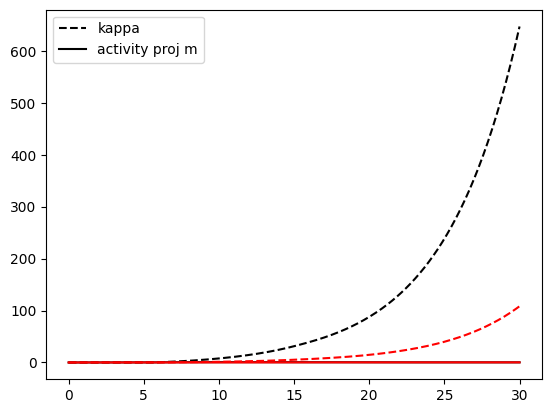

In [7]:
# two trials, one for each input
kappa = [0,0]
v = [0,0]
K = np.zeros((2,len(time)))

for ti in range(len(time)):

    # one input
    s_sigma_mn, s_sigma_nI = np.dot(m,n) / len(m), np.dot(n,IA) / len(m)
    kappa_rec = s_sigma_mn * kappa[0] + s_sigma_nI* v[0]
    v[0] = v[0] + dt*(-v[0] + u[ti])
    kappa[0] = kappa[0] + dt*(-kappa[0] + kappa_rec)

    # second input
    s_sigma_mn, s_sigma_nI = np.dot(m,n) / len(m), np.dot(n,IB) / len(m)
    kappa_rec = s_sigma_mn * kappa[1] + s_sigma_nI* v[1]
    v[1] = v[1] + dt*(-v[1] +  u[ti])
    kappa[1] = kappa[1] + dt*(-kappa[1] + kappa_rec)

    K[:,ti] = kappa


plt.plot(time,K[0],'k--',label='kappa')
plt.plot(time,X[0] @ m / np.linalg.norm(m)**2,'k',label='activity proj m')

plt.plot(time,K[1],'r--')
plt.plot(time,X[1] @ m / np.linalg.norm(m)**2,'r')

plt.legend()

# 3. non-linear low-rank RNN ##

***Exercise 3***

* Use the code provided above to run a *non-linear* network with the same m, n, IA, IB vectors, but with tanh as the transfer function.

* Look at the activations and projections on m and I.

* What changed?

* Generate new set of network vectors in which the overlap between m and n is > 0 (the third case in 1.1)

* how bad is the linear approximation? Why?

# 4. Solving for kappa (non-linear case)

Now that we checked our intutions with the linear case, lets solve $\dot \kappa$ also for the non-linear case. 

There's a way to solve $\kappa$ just using the overlaps (similar to equation 3; we will try that later), but let reduce the dimensionality of our dynamical system just by integrating equation 2.


***Exercise 3.1***
* reuse the code you used above for integreating $\dot x$ and $\dot \kappa$ for the linear case to integrate equation 2.
* compare what you got with the non-linear RNN.

In [8]:

# two trials, one for each input
k_ = np.zeros([2])
K_ = np.zeros((2,len(time)))
v = np.zeros([2])

for ti, _ in enumerate(time):
  # one input
  v[0] = v[0] + dt*(-v[0] + u[ti])
  k_[0] = k_[0] + dt*(-k_[0] + 1/N*n.T @ phi(k_[0]*m + v[0]*IA))

  # second input
  v[1] = v[1] + dt*(-v[1] + u[ti])
  k_[1] = k_[1] + dt*(-k_[1] + 1/N*n.T @ phi(k_[1]*m + v[1]*IB))
  K_[:,ti] = k_



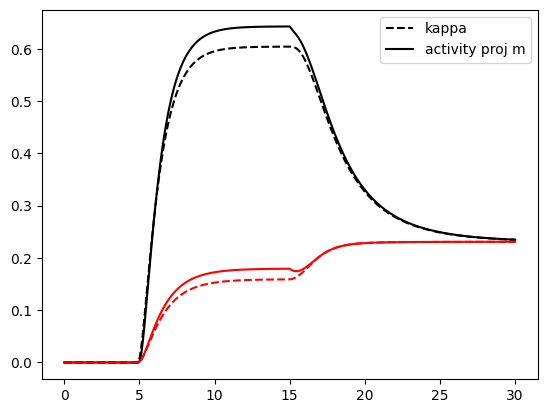

In [9]:
plt.plot(time,K_[0],'k--',label='kappa')
plt.plot(time,K_[1],'r--')

plt.plot(time,X[0] @ m / np.linalg.norm(m)**2,'k',label='activity proj m')
plt.plot(time,X[1] @ m / np.linalg.norm(m)**2,'r')

plt.legend()

#

(bonus) ***Exercise 3.2*** As you saw from the previous example, the main difference between linear neurons and tanh neurons is that the latter saturate. Also in this case it is possible to derive $\dot \kappa = F(\Sigma)$, with $\Sigma$ the overlaps between all network vectors. 

In the case where $\phi(x) = tanh(x)$:

$$ \dot \kappa = -k + \tilde{\sigma}_{nm}\kappa + \tilde{\sigma}_{nI}\kappa_{I} \; \; \; \small (3)$$
$$ \dot \kappa_{I} = -\kappa_{I} + u$$


with:

$\tilde{\sigma}_{ab} = a^Tb/N <\phi'(0,\Delta)>$ 

$\Delta  =  \kappa^2 \sigma_{m}^2 + \kappa_{I}^2\sigma_{I}^2$

The derivation of this can be checked in (Mastrogiuseppe & Ostojic, 2019) and (Dubreuil, Valente et al, 2019). 

Intuitively, the dynamics of $\kappa$ depend no only on the fixed connectivity (i.e. overlaps), but also on the average gain (i.e. $<\phi'>$) that will change depending on the network state.

Using phi_prime function below, integrate $\dot \kappa$ only using the overlaps.


In [10]:
gaussian_norm = (1/np.sqrt(np.pi))
gauss_points, gauss_weights = np.polynomial.hermite.hermgauss(200)
gauss_points = gauss_points*np.sqrt(2)

def phi (mu, delta0):
    integrand = np.tanh(mu+np.sqrt(delta0)*gauss_points)
    return gaussian_norm * np.dot (integrand,gauss_weights)

def phi_prime (mu, delta0):
    integrand = 1 - (np.tanh(mu+np.sqrt(delta0)*gauss_points))**2
    return gaussian_norm * np.dot (integrand,gauss_weights)

def calc_effective_conn(kappa, kappa_I,I,n,overlaps):


  sigma_II = np.dot(I,I)/len(I)
  sigma_nI = np.dot(n,I)/len(I)

  sigma_mm = overlaps[0,0]
  sigma_mn = overlaps[0,1]

  delta =sigma_mm * kappa**2 + sigma_II * kappa_I**2

  s_sigma_mn=sigma_mn * phi_prime(0,delta)
  s_sigma_nI=sigma_nI * phi_prime(0,delta)

  return s_sigma_mn, s_sigma_nI

# two trials, one for each input
kappa = [0,0]
kappa_I = [0,0]
K = np.zeros((2,len(time)))

for ti in range(len(time)):

    # one input
    s_sigma_mn, s_sigma_nI = calc_effective_conn(kappa[0], kappa_I[0],IA,n,lrh.overlaps)
    kappa_rec = s_sigma_mn * kappa[0]+s_sigma_nI *kappa_I[0]
    kappa_I[0] = kappa_I[0] + dt*(-kappa_I[0] +  u[ti])
    kappa[0] = kappa[0] + dt*(-kappa[0] + kappa_rec)

    # second input
    s_sigma_mn, s_sigma_nI = calc_effective_conn(kappa[1], kappa_I[1],IB,n,lrh.overlaps)
    kappa_rec = s_sigma_mn * kappa[1]+s_sigma_nI *kappa_I[1]
    kappa_I[1] = kappa_I[1] + dt*(-kappa_I[1] +  u[ti])
    kappa[1] = kappa[1] + dt*(-kappa[1] + kappa_rec)

    K[:,ti] = kappa


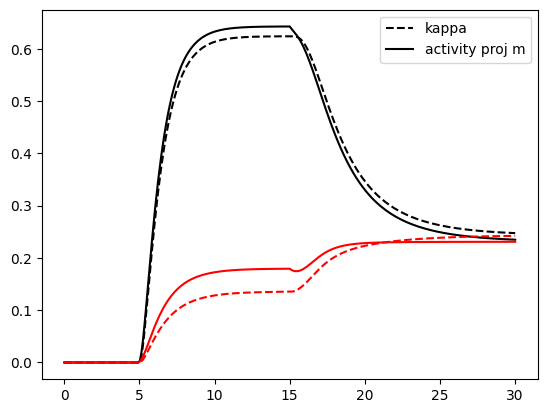

In [11]:
plt.plot(time,K[0],'k--',label='kappa')
plt.plot(time,X[0] @ m / np.linalg.norm(m)**2,'k',label='activity proj m')

plt.plot(time,K[1],'r--')
plt.plot(time,X[1] @ m / np.linalg.norm(m)**2,'r')

plt.legend()